In [ ]:
import os
import re
import warnings
from datetime import datetime
from collections import Counter

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
tf.keras.mixed_precision.set_global_policy('mixed_float16')

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
nltk.download('stopwords')
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Project Overview**
**1. Objective**: The goal of this project is to build a sentiment analysis model using the Neural Network, BiLSTM, and DistilBERT transformer model to classify IMDb movie reviews into positive and negative sentiments. The project aims to automate the sentiment classification process, enabling businesses to analyze customer feedback on movies at scale.

**2. Dataset**: The data is [IMDB movie reviews](https://www.kaggle.com/datasets/pawankumargunjan/imdb-review) on Kaggle, which contain 50,000 labeled reviews (25,000 for training, 25,000 for testing). Each review is labeled as either positive(1) or negative(0). Both train and test set are balanced dataset with 50-50 for two classes. Each has 3 columns: sentence (film review in English), sentiment (ratings), polarity (sentimnet label).

**3. Model Description**:
- DistilBERT is a balance between computational efficiency and performance. DistilBERT is a smaller version of BERT while retaining 97% language understanding. The model consists DistilBERT followed by a classification head that predicts the sentiment (positive or negative). The model is fine-tuned for 3 epochs on IMDB training dataset.

- BiLSTM: is a type of recurrent neural network (RNN) that processes input data in both forward and backward directions. This allows the model to capture context from both the past and the future in sequence data, which is particularly useful for tasks like sentiment classification. It improves accuracy compared to a unidirectional LSTM.

- A Dense Network: consists of fully connected layers where each neuron is connected to every neuron in the previous layer. It directly processes the input features (e.g., word embeddings) through these layers to predict sentiment. The final Dense layer outputting the sentiment prediction.

**4. Result**:
- The DistilBERT achieved **93% F1, and 93% Accuracy** on the balanced test set, indicating strong performance for sentiment analysis.
- LSTM: 86% F1, and 86% Accuracy which is pretty good.
- Dense: 1.00 Recall but achieved only 50% Accuracy and 66.68% F1


# **I. Import Data**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pawankumargunjan/imdb-review")

print("Path to dataset files:", path)

100%|██████████| 111M/111M [00:00<00:00, 215MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3


In [ ]:
for dirname, _, filenames in os.walk(path):
    print(dirname)

/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/train
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/train/unsup
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/train/pos
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/train/neg
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/test
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/test/pos
/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/test/neg


In [ ]:
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)


In [ ]:
# Get the train and test data
train = load_dataset('/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/train')
test = load_dataset('/root/.cache/kagglehub/datasets/pawankumargunjan/imdb-review/versions/3/aclImdb/test')

In [ ]:
train.head(5)

,sentence,sentiment,polarity
0,"Though I saw this movie years ago, its impact ...",10,1
1,I and a friend rented this movie. We both foun...,1,0
2,Easily one of the ten best movies of the 20th ...,9,1
3,"As someone who lived through,and still remembe...",2,0
4,"I don't know what some of you are smoking, but...",1,0


In [ ]:
test.head()

,sentence,sentiment,polarity
0,I'm from Australia and have watched with respe...,3,0
1,I won't be too hard on this show because I enj...,2,0
2,"Scarlet Dawn casts Douglas Fairbanks, Jr. as a...",3,0
3,"Dallas stars Gary Cooper, Ruth Roman, Steve Co...",7,1
4,"In Moscow, the young couple Veronika (T. Samoj...",9,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   25000 non-null  object
 1   sentiment  25000 non-null  object
 2   polarity   25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   25000 non-null  object
 1   sentiment  25000 non-null  object
 2   polarity   25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


# **II. EDA**

**Film Rating Distribution**

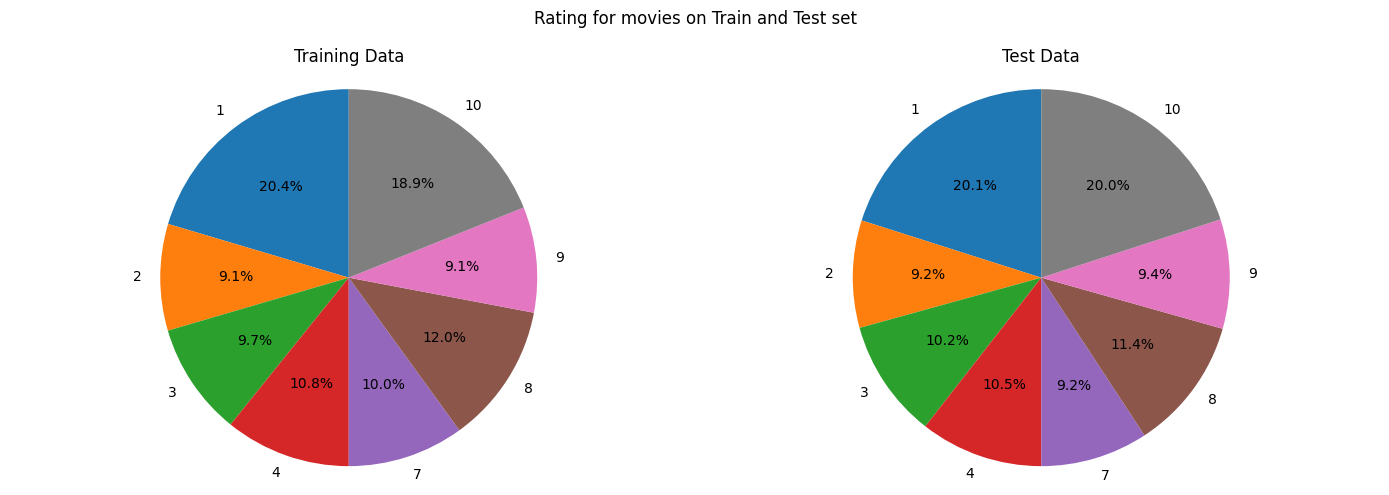

In [ ]:
# Get the rating distribution of Train and Test

# Convert rating from object to number
train['sentiment'] = train['sentiment'].astype(int)
test['sentiment'] = test['sentiment'].astype(int)

# Create data for pie chart
rating_train_agg = train.groupby('sentiment')['sentiment'].count().reset_index(name='count')
rating_test_agg = test.groupby('sentiment')['sentiment'].count().reset_index(name='count')

# Subplot for rating of train and test set
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].pie(rating_train_agg['count'], labels=rating_train_agg['sentiment'], autopct='%1.1f%%', startangle=90)
axes[0].axis('equal')
axes[0].set_title('Training Data')

axes[1].pie(rating_test_agg['count'], labels=rating_test_agg['sentiment'], autopct='%1.1f%%', startangle=90)
axes[1].axis('equal')
axes[1].set_title('Test Data')

plt.suptitle("Rating for movies on Train and Test set")
plt.tight_layout()
plt.show()

The distribution Rating on Train and Test data are similar

**Word Length Distribution**

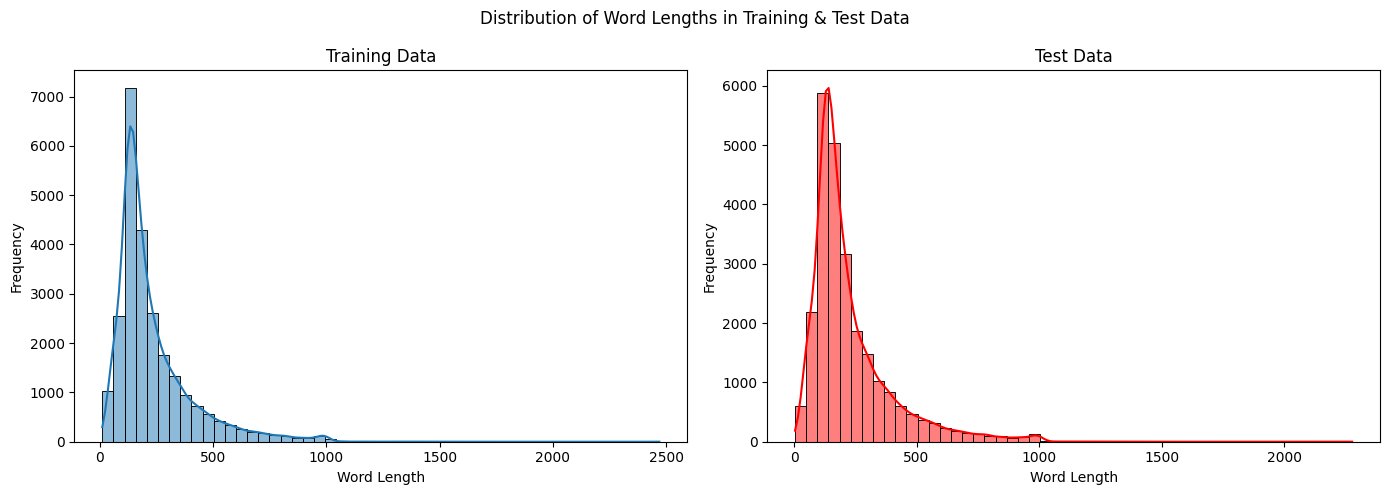

In [ ]:
# Plot the length distribution of Train and Test

# Add text length column
train['word_length'] = train['sentence'].apply(lambda x: len(x.split()))
test['word_length'] = test['sentence'].apply(lambda x: len(x.split()))

# Suplot for length of text
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(train['word_length'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Training Data')
axes[0].set_xlabel('Word Length')
axes[0].set_ylabel('Frequency')

sns.histplot(test['word_length'], bins=50, kde=True, color='red', ax=axes[1])
axes[1].set_title('Test Data')
axes[1].set_xlabel('Word Length')
axes[1].set_ylabel('Frequency')

plt.suptitle("Distribution of Word Lengths in Training & Test Data")
plt.tight_layout()
plt.show()

Most reviews have less than 500 words, however, there are some very long reviews with more than 2500 words.

**Top 10 Words of Negative and Positive Review**

In [ ]:
# Get 10 most common words in Train data for Negative and Positive review
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
extra_stopwords = {"'s", "n't", "'m", "'re", "br"}
stop_words.update(extra_stopwords)

def get_top_words_by_label(dataframe, label, stop_words, n=10):
    """Get top N words for a specific sentiment label"""
    subset = dataframe[dataframe['polarity'] == label]

    all_text = ' '.join(subset['sentence'].tolist()).lower()
    words = re.findall(r"\b[\w']+\b", all_text)

    # Filter words -  Remove nonsense and high frenquency word
    filtered_words = [
        word for word in words
        if word not in stop_words
        and len(word) > 2
        and not word.isdigit()
        and word not in {"movie", "film", "one", "really", "time", "story", "would", "see"}
    ] # These words are not nonsense as a, an, the but they do not provide any insight -> delete

    word_counts = Counter(filtered_words)
    top_words = pd.DataFrame(word_counts.most_common(n),
                            columns=['word', f'count_{"positive" if label else "negative"}'])

    return top_words

top_positive = get_top_words_by_label(train, 1, stop_words)
top_negative = get_top_words_by_label(train, 0, stop_words)

# Display both dataframes
print("Top Words in Positive Reviews:")
display(top_positive)

print("\nTop Words in Negative Reviews:")
display(top_negative)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top Words in Positive Reviews:


,word,count_positive
0,like,9039
1,good,7723
2,great,6419
3,well,6410
4,also,5551
5,even,4964
6,first,4757
7,much,4687
8,people,4394
9,best,4319



Top Words in Negative Reviews:


,word,count_negative
0,like,11241
1,even,7691
2,good,7422
3,bad,7401
4,much,5077
5,get,5024
6,people,4724
7,make,4719
8,could,4569
9,made,4541


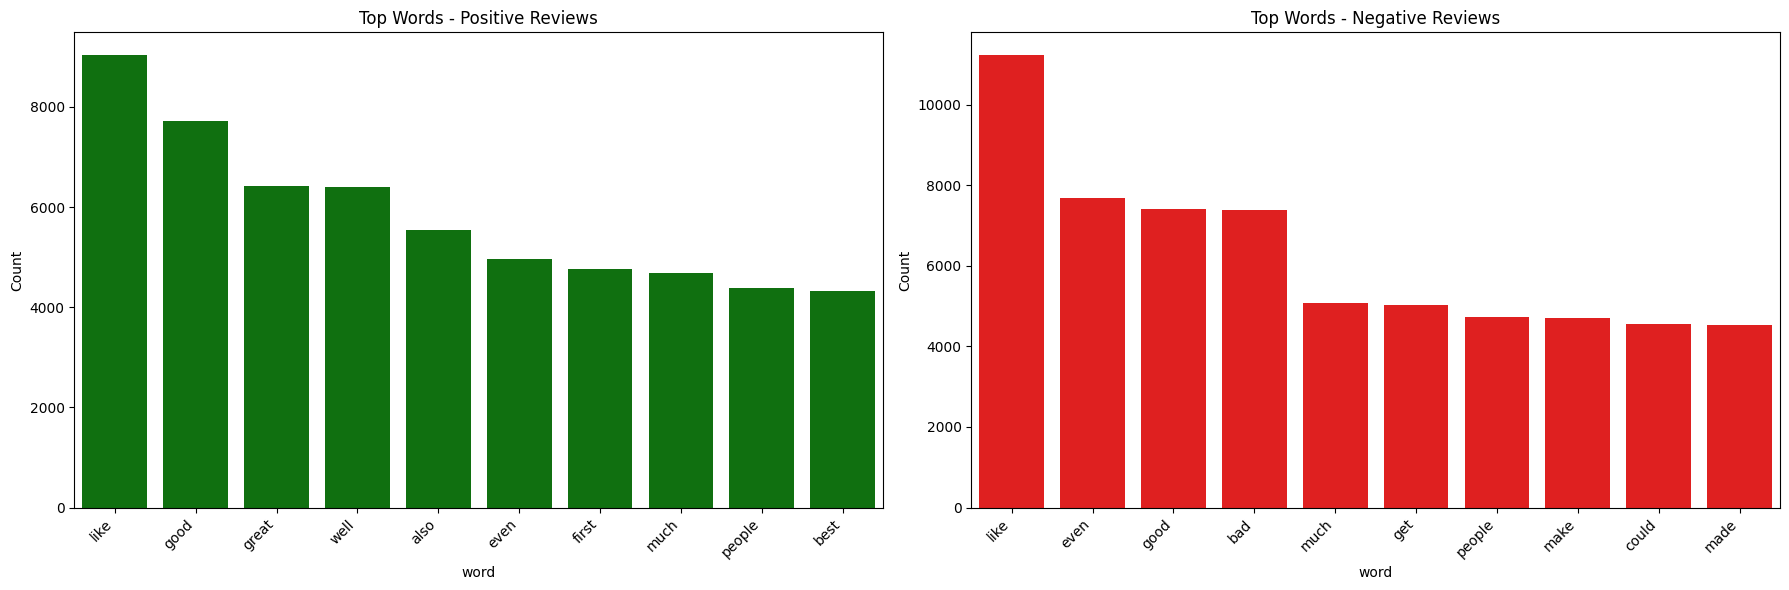

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(data=top_positive, x='word', y='count_positive', ax=ax1, color='green')
ax1.set_title('Top Words - Positive Reviews')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.barplot(data=top_negative, x='word', y='count_negative', ax=ax2, color='red')
ax2.set_title('Top Words - Negative Reviews')
ax2.set_ylabel('Count')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Word Cloud for both Negative and Positive Review**

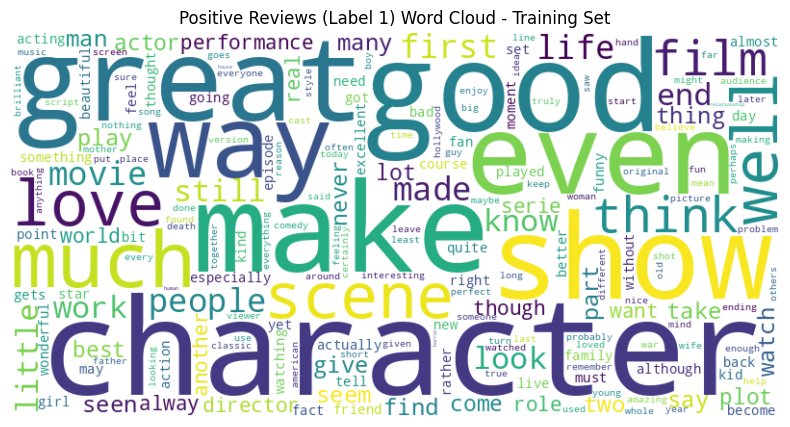

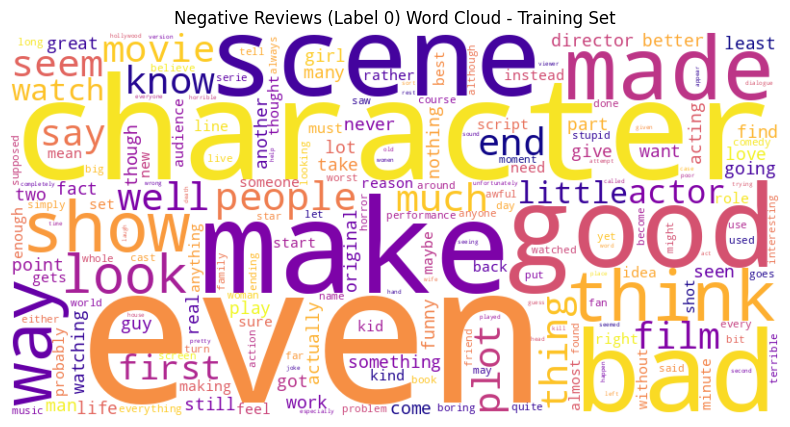

In [ ]:
# Get the Word Cloud for two labels in Train set
from wordcloud import WordCloud
def generate_label_wordcloud(dataframe, label, stop_words, title):
    subset = dataframe[dataframe['polarity'] == label]
    text = ' '.join(subset['sentence'].tolist()).lower()

    words = re.findall(r"\b[\w']+\b", text)
    filtered_words = [
        word for word in words
        if word not in stop_words
        and len(word) > 2
        and not word.isdigit()
        and word not in {"movie", "film", "one", "really", "time", "story", "would", "see"}
    ]
    text = ' '.join(filtered_words)

    # Generate and plot word cloud
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         colormap='viridis' if label else 'plasma').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for both labels
generate_label_wordcloud(train, 1, stop_words,
                        "Positive Reviews (Label 1) Word Cloud - Training Set")
print("="*100)
generate_label_wordcloud(train, 0, stop_words,
                        "Negative Reviews (Label 0) Word Cloud - Training Set")

In [ ]:
# Distribution of word length
print('Distribution of word length in train data')
print(train['word_length'].describe())
print()
print('Distribution of word length in test data')
print(test['word_length'].describe())

Distribution of word length in train data
count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word_length, dtype: float64

Distribution of word length in test data
count    25000.000000
mean       228.526680
std        168.883693
min          4.000000
25%        126.000000
50%        172.000000
75%        277.000000
max       2278.000000
Name: word_length, dtype: float64


75% examples of both train and test set has length under or equal 284. However, the max length is 2470 which is really far beyond the rest of data. I will delete the examples with length more than 284 from the dataset to reduce computational expense (in terms of number of training examples, and the length of tokens) while remain most dataset.

In [ ]:
train = train[train['word_length'] <= 284].reset_index(drop=True)
test = test[test['word_length'] <= 284].reset_index(drop=True)

In [ ]:
# Have a look at customer review on films
pd.options.display.max_colwidth = 200
train.head()

,sentence,sentiment,polarity,word_length
0,"Though I saw this movie years ago, its impact has never left me. Stephen Rea's depiction of an invetigator is deep and moving. His anguish at not being able to stop the deaths is palpable. Everyon...",10,1,92
1,I and a friend rented this movie. We both found the movie soundtrack and production techniques to be lagging. The movie's plot appeared to drag on throughout with little surprise in the ending. We...,1,0,54
2,"As someone who lived through,and still remembers that decade vividly,if the actual '70s had been half this funny and (semi)normal,they would have been so much more enjoyable.Actual kids in that er...",2,0,178
3,"I don't know what some of you are smoking, but i suspect it's potent.<br /><br />To call Swept Away awful would be an insult to the very concept of terribleness. The acting is hideous and i'm not ...",1,0,228
4,"Radiofreccia is a movie about all of us, about our dreams, our friends, our obsessions, our addictions, our fears. It is a brilliant movie where a group of friends like all of us have lives throug...",9,1,230


In [ ]:
# Have a closer look at a review
print(f"Sentiment Label for this review: {train.loc[0, 'sentiment']}")
print('-'*50)
print(train.loc[0, 'sentence'])

Sentiment Label for this review: 10
--------------------------------------------------
Though I saw this movie years ago, its impact has never left me. Stephen Rea's depiction of an invetigator is deep and moving. His anguish at not being able to stop the deaths is palpable. Everyone in the cast is amazing from Sutherland who tries to accommodate him and provide ways for the police to coordinate their efforts, to the troubled citizen x. Each day when we are bombarded with stories of mass murderers, I think of this film and the exhausting work the people do who try to find the killers.


In [ ]:
print('Percentage of pos and neg in train data')
print()
print(train.polarity.value_counts(normalize=True).reset_index())
print()
print()
print('Percentage of pos and neg in test data')
print()
print(test.polarity.value_counts(normalize=True).reset_index())

Percentage of pos and neg in train data

   polarity  proportion
0         0    0.505679
1         1    0.494321


Percentage of pos and neg in test data

   polarity  proportion
0         1    0.500184
1         0    0.499816


After deleting long sentence, both train and test data still have a balance of negative and positive review which is really good. And there is no need for resampling training data.

In [ ]:
print(f"Numner of example in Train data: {train.shape[0]}")
print(f"Numner of example in Test data: {test.shape[0]}")

Numner of example in Train data: 18753
Numner of example in Test data: 19007


# **III. Preprocessing**

**Prepare Data for DistilBERT**

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
      # Tokenization with truncate and padding
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_length
        )
        self.labels = labels

    def __getitem__(self, idx):
      # Tensor conversion
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

In [ ]:
# Get the max length for padding purpose
max_length = max(max(train['word_length']), max(test['word_length']))
max_length_set = int(max_length*1.2)
print(f"Max length: {max_length}")
print(f"Max length set: {max_length_set}")

# Initialize tokenizer with max length
bert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Max length: 284
Max length set: 340


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Data preparation
train_dataset = SentimentDataset(
    train['sentence'].tolist(),
    train['polarity'].tolist(),
    bert_tokenizer,
    max_length_set
)

test_dataset = SentimentDataset(
    test['sentence'].tolist(),
    test['polarity'].tolist(),
    bert_tokenizer,
    max_length_set
)

In [ ]:
# Have a look at train_dataset and its original sentence
sample = train_dataset[0]

print("Input IDs:", sample['input_ids'])
print("Attention Mask:", sample['attention_mask'])
print("Label:", sample['labels'])

# Get original sentence
decoded_text = bert_tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
print("\nDecoded Text:", decoded_text)

Input IDs: tensor([  101,  2295,  1045,  2387,  2023,  3185,  2086,  3283,  1010,  2049,
         4254,  2038,  2196,  2187,  2033,  1012,  4459,  2128,  2050,  1005,
         1055, 15921,  1997,  2019,  1999, 19510, 13340,  4263,  2003,  2784,
         1998,  3048,  1012,  2010, 21782,  2012,  2025,  2108,  2583,  2000,
         2644,  1996,  6677,  2003, 14412,  4502,  3468,  1012,  3071,  1999,
         1996,  3459,  2003,  6429,  2013, 14274,  2040,  5363,  2000,  8752,
         2032,  1998,  3073,  3971,  2005,  1996,  2610,  2000, 13530,  2037,
         4073,  1010,  2000,  1996, 11587,  6926,  1060,  1012,  2169,  2154,
         2043,  2057,  2024,  5968, 28037,  2007,  3441,  1997,  3742, 28882,
         1010,  1045,  2228,  1997,  2023,  2143,  1998,  1996, 15095,  2075,
         2147,  1996,  2111,  2079,  2040,  3046,  2000,  2424,  1996, 15978,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

**Prepare Data for BiLSTM and Dense Neural Network**

In [ ]:
# Parameters
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 256
EMBED_DIM = 64
BATCH_SIZE = 256
EPOCHS = 20

# Tokenization
keras_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
keras_tokenizer.fit_on_texts(train['sentence'])

X_train = pad_sequences(keras_tokenizer.texts_to_sequences(train['sentence']),
                       maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(keras_tokenizer.texts_to_sequences(test['sentence']),
                      maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_train = train['polarity'].values
y_test = test['polarity'].values

# **IV. Training**

**First Model: Dense**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks setup
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
model_dense = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS + 1, 128, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

dense_checkpoint = ModelCheckpoint(
    'best_dense.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Training
history_dense = model_dense.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, dense_checkpoint],
    verbose=1
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4925 - loss: 0.6932
Epoch 1: val_accuracy improved from -inf to 0.49929, saving model to best_dense.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.4925 - loss: 0.6932 - val_accuracy: 0.4993 - val_loss: 0.6931
Epoch 2/20
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4936 - loss: 0.6931
Epoch 2: val_accuracy did not improve from 0.49929
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4935 - loss: 0.6931 - val_accuracy: 0.4993 - val_loss: 0.6931
Epoch 3/20
62/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4979 - loss: 0.6930
Epoch 3: val_accuracy did not improve from 0.49929
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4974 - loss: 0.6930 - val_accuracy: 0.4993 - val_loss: 0.6931
Epoch 4/20
61/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5040 - loss: 0.6930
Epoch 4: val_accuracy did not improve from 0.49929
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5022 - loss: 0.6931 - val_accuracy: 0.4993 - val_loss: 0.6931
Epoch 5/20
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4996 - loss: 0.6931
Epoch 5: val_accuracy did not improve from 0.4992

**Second Model: LSTM**

In [ ]:
# Model definition
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS + 1, EMBED_DIM, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

bilstm_checkpoint = ModelCheckpoint(
    'best_bilstm.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Training
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, bilstm_checkpoint],
    verbose=1
)

Epoch 1/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5613 - loss: 0.6655
Epoch 1: val_accuracy improved from -inf to 0.80055, saving model to best_bilstm.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.5638 - loss: 0.6636 - val_accuracy: 0.8005 - val_loss: 0.4551
Epoch 2/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8370 - loss: 0.3949
Epoch 2: val_accuracy improved from 0.80055 to 0.83306, saving model to best_bilstm.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8375 - loss: 0.3942 - val_accuracy: 0.8331 - val_loss: 0.3728
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8880 - loss: 0.2924
Epoch 3: val_accuracy improved from 0.83306 to 0.85837, saving model to best_bilstm.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8881 - loss: 0.2922 - val_accuracy: 0.8584 - val_loss: 0.3520
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9185 - loss: 0.2267
Epoch 4: val_accuracy did not improve from 0.85837
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9186 - loss: 0.2266 - val_accuracy: 0.8582 - val_loss: 0.3995
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9347 - loss: 0.1965
Epoch 5: val_accuracy did not improve from 0.85837
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9347 - loss: 0.1964 - val_accuracy: 0.8549 - val_loss: 0.4337
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9362 - loss: 0.1874
Epoch 6: val_accuracy did not improve from 0.85837
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9362 - loss: 0.1875 - val_accuracy: 0.8487 - val_loss: 0.4599
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9383 - loss: 0.1778
Epoch 7: val_accuracy did not improve fro

**Third Model: DistilBERT**

In [ ]:
from datetime import datetime
# Get DistilBERT

# Version control setup
MODEL_VERSION = "v1"
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_SAVE_NAME = f"sentiment_model_{MODEL_VERSION}_{TIMESTAMP}"
MODEL_SAVE_PATH = os.path.join('./saved_models', MODEL_SAVE_NAME)

# Check for saved model, else get pre_trained model
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading existing model: {MODEL_SAVE_NAME}")
    model = DistilBertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
else:
    print(f"Initializing new model: {MODEL_SAVE_NAME}")
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2
    )

Initializing new model: sentiment_model_v1_20250507_1531


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Function for metric calcualtion
def compute_metrics(p):
    """
    Calculate multiple evaluation metrics for classification
    Uses sklearn metrics for compatibility with Hugging Face outputs
    """
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1': f1_score(p.label_ids, preds),
        'precision': precision_score(p.label_ids, preds),
        'recall': recall_score(p.label_ids, preds)
    }

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"🎯 Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"💻 Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ Warning: No GPU detected, training will be slow!")


🎯 Using GPU: Tesla T4
💻 Total GPU Memory: 14.74 GB


In [ ]:
# Only train if model doesn't exist
if not os.path.exists(MODEL_SAVE_PATH):
  # Training arguments
  training_args = TrainingArguments(
      output_dir='./results',          # Directory for checkpoints
      num_train_epochs=3,
      per_device_train_batch_size=64,  # Batch size in training
      per_device_eval_batch_size=128,  # Batch size in evaluation
      warmup_ratio=0.1,                # 10% of training steps for learning rate warmup
      weight_decay=0.01,               # Regularization
      learning_rate=2e-5,              # Small rate for fine-tuning
      eval_strategy='epoch',           # Evaluate after each epoch
      save_strategy='epoch',           # Save checkpoint after each epoch
      load_best_model_at_end=True,
      fp16=True,
      report_to='none',                # Disable external services logging
      optim='adamw_torch',
      gradient_accumulation_steps=1,   # No accumulation needed with current batch size
  )

  # Trainer initialization
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
  )

  # Training process and saving model
  print("Starting training...")
  trainer.train()
  print("Training completed! Saving model...")
  model.save_pretrained(MODEL_SAVE_PATH)
  bert_tokenizer.save_pretrained(MODEL_SAVE_PATH)

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.199974,0.923081,0.925217,0.900528,0.951299
2,0.263300,0.181201,0.932341,0.932309,0.933095,0.931524
3,0.263300,0.199559,0.931183,0.931114,0.932391,0.929841


Training completed! Saving model...


# **V. Evaluation**

In [ ]:
def evaluate_models(X_test, y_test, test_texts, test_labels, max_length_set):
    '''Get metric of 3 models, putting into a dataframe, and then plotting confusion matrix'''
    # Initialize results storage
    metrics = []
    predictions = {}

    # Evaluate Dense Model
    model_dense = tf.keras.models.load_model('best_dense.h5')
    y_pred_dense = (model_dense.predict(X_test) > 0.5).astype(int)

    metrics.append({
        'Model': 'Dense Network',
        'Accuracy': accuracy_score(y_test, y_pred_dense),
        'Precision': precision_score(y_test, y_pred_dense),
        'Recall': recall_score(y_test, y_pred_dense),
        'F1': f1_score(y_test, y_pred_dense)
    })
    predictions['Dense'] = y_pred_dense

    # Evaluate BiLSTM Model
    model_bilstm = tf.keras.models.load_model('best_bilstm.h5')
    y_pred_bilstm = (model_bilstm.predict(X_test) > 0.5).astype(int)

    metrics.append({
        'Model': 'BiLSTM',
        'Accuracy': accuracy_score(y_test, y_pred_bilstm),
        'Precision': precision_score(y_test, y_pred_bilstm),
        'Recall': recall_score(y_test, y_pred_bilstm),
        'F1': f1_score(y_test, y_pred_bilstm)
    })
    predictions['BiLSTM'] = y_pred_bilstm

    # Evaluate DistilBERT
    model = DistilBertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
    bert_tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_SAVE_PATH)

    # Recreate test dataset
    bert_dataset = SentimentDataset(
        test_texts,
        test_labels,
        bert_tokenizer,
        max_length_set
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    test_loader = DataLoader(bert_dataset, batch_size=64, shuffle=False)
    bert_preds = []
    bert_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            bert_preds.extend(preds.cpu().numpy())
            bert_labels.extend(labels.cpu().numpy())

    metrics.append({
        'Model': 'DistilBERT',
        'Accuracy': accuracy_score(bert_labels, bert_preds),
        'Precision': precision_score(bert_labels, bert_preds),
        'Recall': recall_score(bert_labels, bert_preds),
        'F1': f1_score(bert_labels, bert_preds)
    })
    predictions['DistilBERT'] = bert_preds

    # Create metrics dataframe
    metrics_df = pd.DataFrame(metrics).set_index('Model')

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for i, (name, pred) in enumerate(predictions.items()):
        if name == 'DistilBERT':
            labels = bert_labels
        else:
            labels = y_test

        cm = confusion_matrix(labels, pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i])
        axes[i].set_title(f'{name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

    return metrics_df, predictions

594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


594/594 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step


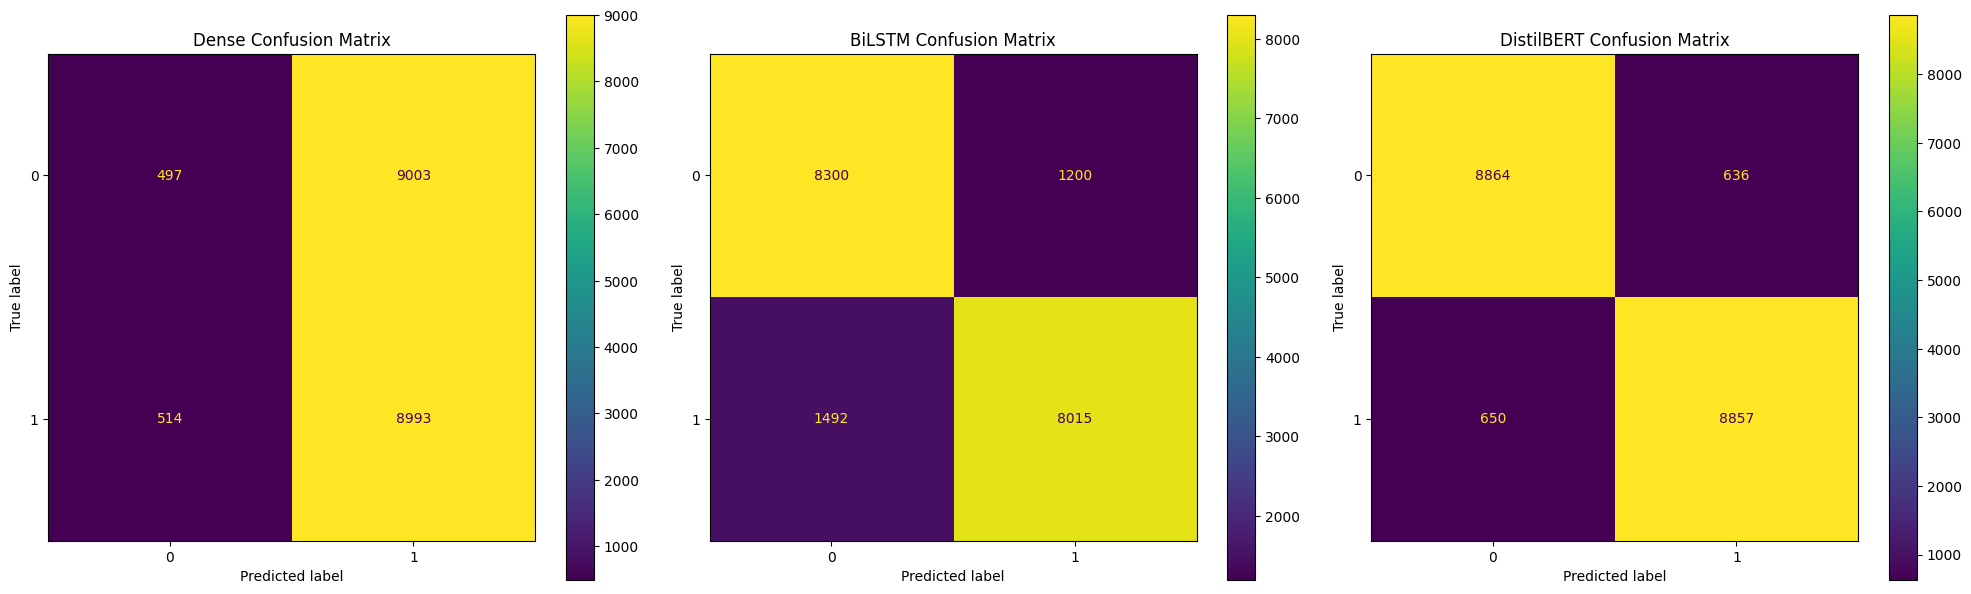

Model Comparison Metrics:


,Accuracy,Precision,Recall,F1
Model,,,,
Dense Network,0.499290,0.499722,0.945935,0.653965
BiLSTM,0.858368,0.869778,0.843063,0.856212
DistilBERT,0.932341,0.933003,0.931629,0.932316


In [ ]:
# Run evaluation
test_texts = test['sentence'].tolist()
test_labels = test['polarity'].tolist()
metrics_df, predictions = evaluate_models(X_test, y_test, test_texts, test_labels, max_length_set)

# Display metrics
print("Model Comparison Metrics:")
display(metrics_df.style.background_gradient(cmap='Blues', axis=0))